# 추천 시스템 - 영화 데이터셋과 Rating Matrix를 활용하여 추천 모델 학습하기

- MovieLens Dataset

1.  ratings.dat <br>
  user_id : 영화를 시청한 사용자 아이디 <br>
  movie_id : 영화의 아이디 <br>
  rating : 평가점수 <br>
  time : 영화 시청 시간 <br>
<hr>
2.  movies_dat <br>
  movie_id : 영화의 아이디
  title : 영화 제목<br>
  genre : 영화 장르

### 데이터 전처리

In [1]:
# 데이터 불러오기
import pandas as pd

rating_url = "https://raw.githubusercontent.com/yoonkt200/python-data-analysis/master/data/ml-1m/ratings.dat"
rating_df = pd.io.parsers.read_csv(rating_url, names=["user_id", "movie_id", "rating", "time"], delimiter ='::', engine='python')
rating_df.head()

,user_id,movie_id,rating,time
0,1,1193,5,978300760
1,1,661,3,978302109
2,1,914,3,978301968
3,1,3408,4,978300275
4,1,2355,5,978824291


In [2]:
movie_url = "https://raw.githubusercontent.com/yoonkt200/python-data-analysis/master/data/ml-1m/movies.dat"
movie_df = pd.io.parsers.read_csv(movie_url, names=["movie_id", "title", "genre"], delimiter ='::', engine='python', encoding='ISO-8859-1')
movie_df.head()

,movie_id,title,genre
0,1,Toy Story (1995),Animation|Children's|Comedy
1,2,Jumanji (1995),Adventure|Children's|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama
4,5,Father of the Bride Part II (1995),Comedy


In [3]:
# 사용자 수
len(rating_df["user_id"].unique())

6040

In [4]:
# 영화 수
len(rating_df["movie_id"].unique())

3706

In [5]:
import matplotlib.pyplot as plt

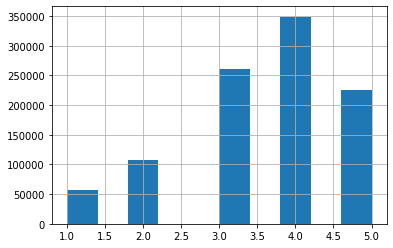

In [6]:
# 영화 평가 점수 분포
rating_df['rating'].hist();

### CF-based 모델링(KNN)

### Rating Matrix와 Colaborative Filtering(CF)

- 1. User를 Row, Item을 Column으로 하며 Value를 Rating으로 하는 행렬
- 2. Rating의 종류
  > Explicit Feedback : 영화 점수, 리뷰 점수, 좋아요 표시 ...<br>
  > Implicit Feedback : 조회, 시청, 구매, 찜 표시 ...
- 3. Rating Matrix를 추천 모델로 활용하는 방법
  > Colaborative Filtering (CF) <br>
  > Matrix Factorization (MF)

### Train/Test 데이터 분리

In [7]:
!pip install surprise

In [8]:
from surprise import Dataset, Reader
from surprise.model_selection import train_test_split

reader = Reader(rating_scale=(1,5)) # 1점부터 5점까지
data = Dataset.load_from_df(rating_df[["user_id", "movie_id", "rating"]], reader) # 행, 열, 행과 열이 만나는 지점에서의 rating 값
trainset, testset = train_test_split(data, test_size=0.25)

### KNN 모델 학습
- KNN? (K-Nearest Neighbor)
  - 1. 새로운(혹은 특정한) 데이터 포인트 X가 있을 때, X와 가장 유사한 k개를 이용하여 데이터 포인트 X의 위치를 찾는 알고리즘
  - 2. euclidean distance, cosine similarity 등을 기준으로 유사한 k개를 계산
  - 3. 분류(classification) 문제의 경우는 k개의 포인트에서 가장 많이 등장한 class로 할당
  - 4. 예측(regression) 문제의 경우는 k개 포인트의 평군 값, 혹은 가중치 값 등으로 X의 값을 예측.

In [9]:
# KNN 예제 코드
ab = (0.9 * 4) + (0.8 * 3) + (0.7 * 5) + (0.6 * 1)
bb = (0.9) + 0.8 + 0.7 + 0.6

ab/bb

3.3666666666666663

In [10]:
from surprise import KNNBasic
from surprise import accuracy

algo = KNNBasic(k=40, min_k=1, sim_options={"user_based":True, "name":"cosine"})
algo.fit(trainset)
predictions=algo.test(testset)

Computing the cosine similarity matrix...
Done computing similarity matrix.


### 모델링 - RMSE 평가

In [11]:
accuracy.rmse(predictions)

RMSE: 0.9767


0.9766985336728236

In [12]:
# 테스트 데이터셋 일부 결과 확인 - 모델평가
predictions = algo.test(testset[:20])

In [13]:
predictions

[Prediction(uid=1837, iid=2761, r_ui=4.0, est=4.349341470453839, details={'actual_k': 40, 'was_impossible': False}),
 Prediction(uid=2944, iid=2144, r_ui=5.0, est=4.0495187737850795, details={'actual_k': 40, 'was_impossible': False}),
 Prediction(uid=4953, iid=3362, r_ui=4.0, est=4.149852221184228, details={'actual_k': 40, 'was_impossible': False}),
 Prediction(uid=5390, iid=1556, r_ui=3.0, est=1.975583927377725, details={'actual_k': 40, 'was_impossible': False}),
 Prediction(uid=889, iid=1644, r_ui=2.0, est=2.901636008760206, details={'actual_k': 40, 'was_impossible': False}),
 Prediction(uid=3682, iid=105, r_ui=4.0, est=3.424336216870276, details={'actual_k': 40, 'was_impossible': False}),
 Prediction(uid=4673, iid=2151, r_ui=5.0, est=3.3757998648568694, details={'actual_k': 40, 'was_impossible': False}),
 Prediction(uid=309, iid=1250, r_ui=4.0, est=4.525125298495413, details={'actual_k': 40, 'was_impossible': False}),
 Prediction(uid=26, iid=1994, r_ui=2.0, est=3.571781662935389, de

### MF-Based Modeling
- MF의 대략적인 이해
  - 1. 원래의 행렬을 다른 2개 행렬로 분해하고, 이를 다시 원래 모양으로 만드는 과정을 Factorization이라고 함.
  - 2. 그 과정에서 Latent Facotr 라는 것을 활용하여, 행과 열의 성질을 만들어낼 수 있음.
  - 3. latent factor를 충분히 많이 만들게 되면, 유저와 아이템의 성질을 벡터로 표현 가능.
  - 4. 일반적으로 지도 학습을 통해 P와 Q를 찾게 되고, 이를 Model-based CF라고 하기도 함.

In [14]:
reader = Reader(rating_scale=(1,5)) # 1점부터 5점까지
data = Dataset.load_from_df(rating_df[["user_id", "movie_id", "rating"]], reader) # 행, 열, 행과 열이 만나는 지점에서의 rating 값
trainset, testset = train_test_split(data, test_size=0.25)

In [15]:
from surprise import SVD
from surprise import accuracy

algo = SVD()
algo.fit(trainset)
predictions = algo.test(testset)

In [16]:
# RMSE 평가
accuracy.rmse(predictions)

RMSE: 0.8768


0.8767948231603048

### 모델링 & 시각화 - RMSE를 개선하는 파라미터 튜닝 자동화

In [17]:
import time

param_list = [10, 50, 100, 150, 200]
rmse_list_by_factors = []
ttime_list_by_factors = []
for n in param_list:
  train_start = time.time()
  algo = SVD(n_factors=n)
  algo.fit(trainset)
  train_end = time.time()
  print("training time of model: %.2f seconds" % (train_end - train_start))
  print("RMSE of test dataset in SVD model, n_factors=" + str(n))
  predictions = algo.test(testset)
  rmse_result = accuracy.rmse(predictions)
  rmse_list_by_factors.append(rmse_result)
  ttime_list_by_factors.append((train_end - train_start))
  print("---------------------")
print("searching n_factors is finish.")

training time of model: 17.59 seconds
RMSE of test dataset in SVD model, n_factors=10
RMSE: 0.8793
---------------------
training time of model: 27.93 seconds
RMSE of test dataset in SVD model, n_factors=50
RMSE: 0.8742
---------------------
training time of model: 40.32 seconds
RMSE of test dataset in SVD model, n_factors=100
RMSE: 0.8775
---------------------
training time of model: 53.47 seconds
RMSE of test dataset in SVD model, n_factors=150
RMSE: 0.8805
---------------------
training time of model: 65.88 seconds
RMSE of test dataset in SVD model, n_factors=200
RMSE: 0.8826
---------------------
searching n_factors is finish.


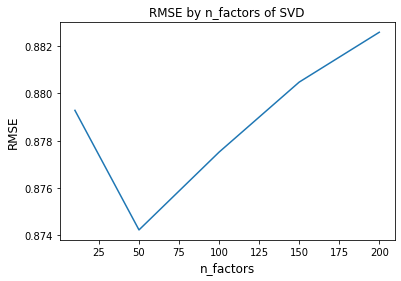

In [18]:
plt.plot(param_list, rmse_list_by_factors)
plt.title("RMSE by n_factors of SVD")
plt.ylabel("RMSE", fontsize=12)
plt.xlabel("n_factors", fontsize=12)
plt.show()

In [19]:
 # 최종 RMSE 평가
algo = SVD(n_factors=50)
algo.fit(trainset)
predictions = algo.test(testset)
accuracy.rmse(predictions)

RMSE: 0.8744


0.8744076201226879

In [20]:
# 테스트 데이터 셋에서 일부 결과 확인
predictions = algo.test((testset[:20]))

In [21]:
predictions

[Prediction(uid=5005, iid=1033, r_ui=3.0, est=3.4379882730078646, details={'was_impossible': False}),
 Prediction(uid=1181, iid=517, r_ui=3.0, est=2.610580112388728, details={'was_impossible': False}),
 Prediction(uid=3647, iid=111, r_ui=4.0, est=3.802884629136167, details={'was_impossible': False}),
 Prediction(uid=1447, iid=2167, r_ui=4.0, est=2.7134340666257737, details={'was_impossible': False}),
 Prediction(uid=3904, iid=1704, r_ui=4.0, est=4.452993856131766, details={'was_impossible': False}),
 Prediction(uid=3704, iid=3879, r_ui=4.0, est=3.2567756315564784, details={'was_impossible': False}),
 Prediction(uid=4956, iid=1282, r_ui=4.0, est=4.479999459517203, details={'was_impossible': False}),
 Prediction(uid=3576, iid=1209, r_ui=4.0, est=3.7469486098477365, details={'was_impossible': False}),
 Prediction(uid=3942, iid=16, r_ui=5.0, est=3.5466489175961184, details={'was_impossible': False}),
 Prediction(uid=311, iid=260, r_ui=5.0, est=4.397300580619771, details={'was_impossible': 

### 추천 결과 평가
- 가정 : 사용자의 과거 Preference는 미래에서도 동일하다
- 1. Time Series로 추정된 선호도가 아닌, Estimate 되거나 Factorized된 점수
- 2. A시점에 평가한 선호도와, B시점에 평가한 선호도가 동일 선에서 학습됨.
- 3. Test 데이터에 대한 평가 역시, 시간이 고려되지 않은 "랜덤한 빈 공간 찾기" 식으로 평가됨.

In [22]:
# 추천 결과 평가 - 사용자별 전체 시청리스트 추출
user_watch_dict_list = rating_df.groupby('user_id')[['user_id', 'movie_id']].apply(lambda x: x["movie_id"].tolist())

In [23]:
user_watch_dict_list[:5]

user_id
1    [1193, 661, 914, 3408, 2355, 1197, 1287, 2804,...
2    [1357, 3068, 1537, 647, 2194, 648, 2268, 2628,...
3    [3421, 1641, 648, 1394, 3534, 104, 2735, 1210,...
4    [3468, 1210, 2951, 1214, 1036, 260, 2028, 480,...
5    [2987, 2333, 1175, 39, 288, 2337, 1535, 1392, ...
dtype: object

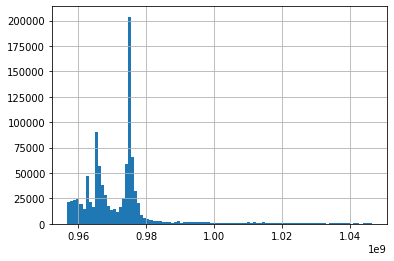

In [24]:
# 특정 시간 기준 사용자별 Train/Test  시청리스트 추출
rating_df["time"].hist(bins=100)

In [25]:
rating_df["time"].quantile(q=0.8, interpolation='nearest')

975768738

In [26]:
train_df = rating_df[rating_df['time'] < 975768738][["user_id", "movie_id", "rating"]]
test_df = rating_df[rating_df['time'] >= 975768738][["user_id", "movie_id", "rating"]]

In [27]:
train_df.shape

(800164, 3)

In [28]:
test_df.shape

(200045, 3)

In [29]:
len(train_df["user_id"].unique())

5400

In [30]:
len(test_df["user_id"].unique())

1783

In [31]:
len(train_df["movie_id"].unique())

3662

In [32]:
len(test_df["movie_id"].unique())

3511

In [33]:
user_watch_dict_list_test = test_df.groupby('user_id')[['user_id', 'movie_id']].apply(lambda x: x["movie_id"].tolist())

In [34]:
user_watch_dict_list_test[:5]

user_id
1    [1193, 661, 914, 3408, 2355, 1197, 1287, 2804,...
2    [1357, 3068, 1537, 647, 2194, 648, 2268, 2628,...
3    [3421, 1641, 648, 1394, 3534, 104, 2735, 1210,...
4    [3468, 1210, 2951, 1214, 1036, 260, 2028, 480,...
5    [2987, 2333, 1175, 39, 288, 2337, 1535, 1392, ...
dtype: object

In [35]:
# 추천 결과 평가 - 모델 기반 사용자별 선호 시청리스트 추출
data = Dataset.load_from_df(df=train_df, reader=reader)
train_data = data.build_full_trainset()
algo = SVD(n_factors=50)
algo.fit(train_data)

In [36]:
test_data = train_data.build_anti_testset()

In [37]:
predictions = algo.test(test_data[:20])

In [38]:
predictions

[Prediction(uid=635, iid=2054, r_ui=3.590506446178533, est=3.4071531115077733, details={'was_impossible': False}),
 Prediction(uid=635, iid=589, r_ui=3.590506446178533, est=4.207440313180937, details={'was_impossible': False}),
 Prediction(uid=635, iid=1261, r_ui=3.590506446178533, est=3.8926548654212967, details={'was_impossible': False}),
 Prediction(uid=635, iid=3016, r_ui=3.590506446178533, est=3.6531569722535737, details={'was_impossible': False}),
 Prediction(uid=635, iid=1274, r_ui=3.590506446178533, est=3.9832530116970406, details={'was_impossible': False}),
 Prediction(uid=635, iid=2094, r_ui=3.590506446178533, est=3.5892785612369824, details={'was_impossible': False}),
 Prediction(uid=635, iid=780, r_ui=3.590506446178533, est=3.956469631744303, details={'was_impossible': False}),
 Prediction(uid=635, iid=1603, r_ui=3.590506446178533, est=3.325529859458823, details={'was_impossible': False}),
 Prediction(uid=635, iid=2288, r_ui=3.590506446178533, est=4.01529478257732, details=

### 예상 선호리스트와 실제 시청리스트로 MAP@K 계산
- [Confusion Matrix와 Recall]
  - 1. 분류 문제에서 사용하는 대표적인 평가 기준
  - 2. 무언가의 실제 클래스(binary), 그리고 예상한 클래스(binary)를 비교하기 위한 매트릭스
  - 3. 이 중 Precision은 흔히 "정확도"이라고 불리는 지표로, 맞다고 예측한 것 중에 실제로 맞는 것의 비율을 의미함.

- [추천시스템과 Precision, Recall]
  - 1. 추천시스템에 이를 대입해보자
  - 2. 유저 A가 실제로 시청한 영화들을 a, 모델이 유저 A가 볼 것이라고 예측한 영화들을 b라고 가정.
  - 3. 이 때 모델이 10개의 영화를 예측햇다면 Top 10 Precision을 계산할 수 있음.
  - 4. Recall 역시 마찬가지의 방법으로 구할 수 있음.
  - 5. Precision과 Recall에 대한 선택 기준은 상황마다 다르지만, 추천시스템에서 일반적으로 사용하는 지표는 "MAP"
  - 6. MAP(Mean Average Precision) : 추천시스템에서는 각 유저마다의 Precision을 계산한 뒤, 이것을 모든 추천 대상 유저로 확장하여 평균적인 지표를 계산.

In [39]:
predictions = algo.test(test_data)
estimated_unwatched_dict = {}

for uid, iid, _, predicted_rating, _ in predictions:
  if uid in estimated_unwatched_dict:
    estimated_unwatched_dict[uid].append((iid, predicted_rating))
  else:
    estimated_unwatched_dict[uid] = [(iid, predicted_rating)]

In [40]:
# str(estimated_unwatched_dict)[:3] - 램 부족으로 실행 불가

In [41]:
# 4점 이상을 준 test 시청리스트만 추출
user_watch_dict_list_test = test_df[test_df['rating']>=4].groupby('user_id')[['user_id', 'movie_id']].apply(lambda x: x["movie_id"].tolist())